# Assignment 1 - Creating and Manipulating Graphs

Eight employees at a small company were asked to choose 3 movies that they would most enjoy watching for the upcoming company movie night. These choices are stored in the file `assets/Employee_Movie_Choices.txt`.

A second file, `assets/Employee_Relationships.txt`, has data on the relationships between different coworkers. 

The relationship score has value of `-100` (Enemies) to `+100` (Best Friends). A value of zero means the two employees haven't interacted or are indifferent.

Both files are tab delimited.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np

In [30]:
# This is the set of employees
employees = set(['Pablo',
                 'Lee',
                 'Georgia',
                 'Vincent',
                 'Andy',
                 'Frida',
                 'Joan',
                 'Claude'])

# This is the set of movies
movies = set(['The Shawshank Redemption',
              'Forrest Gump',
              'The Matrix',
              'Anaconda',
              'The Social Network',
              'The Godfather',
              'Monty Python and the Holy Grail',
              'Snakes on a Plane',
              'Kung Fu Panda',
              'The Dark Knight',
              'Mean Girls'])


# you can use the following function to plot graphs
# make sure to comment it out before submitting to the autograder
def plot_graph(G, weight_name=None):
    '''
    G: a networkx G
    weight_name: name of the attribute for plotting edge weights (if G is weighted)
    '''
    #%matplotlib notebook
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8,8))
    pos = nx.spring_layout(G)
    edges = G.edges()
    weights = None
    
    if weight_name: # weight_name이 None이 아닌 경우...
        weights = [int(G[u][v][weight_name]) for u,v in edges]
        labels = nx.get_edge_attributes(G,weight_name)
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        nx.draw_networkx(G, pos, width=weights);
    else:
        nx.draw_networkx(G, pos,);

### Question 1

Using NetworkX, load in the bipartite graph from `assets/Employee_Movie_Choices.txt` and return that graph.

*This function should return a bipartite networkx graph with 19 nodes and 24 edges*

In [41]:
def answer_one():
    # YOUR CODE HERE
    e = nx.read_adjlist("assets/Employee_Movie_Choices.txt", delimiter='\t')
    B = nx.Graph()
    B.add_nodes_from(employees, bipartite=0)
    B.add_nodes_from(movies, bipartite=1)
    B.add_edges_from((e.edges()))
    return B

### Question 2

Using the graph from the previous question, add nodes attributes named `'type'` where movies have the value `'movie'` and employees have the value `'employee'` and return that graph.

*This function should return a bipartite networkx graph with node attributes `{'type': 'movie'}` or `{'type': 'employee'}`*

In [51]:
def answer_two(): 
    # YOUR CODE HERE
    G = answer_one()
    for node in G.nodes():
        if node in employees:
            G.add_node(node,type="employee")
        else:
            G.add_node(node, type="movie")
    return G

In [52]:
assert type(answer_two()) == nx.Graph , "Your return type should be a Graph object"


### Question 3

Find a weighted projection of the graph from `answer_two` which tells us how many movies different pairs of employees have in common.

*This function should return a weighted projected graph.*

In [53]:
def answer_three():
    # YOUR CODE HERE
    from networkx.algorithms import bipartite
    G = answer_two()
    X = employees
    P = bipartite.weighted_projected_graph(G,X)
    return P

EdgeDataView([('Vincent', 'Frida', {'weight': 2}), ('Vincent', 'Pablo', {'weight': 1}), ('Frida', 'Pablo', {'weight': 2}), ('Frida', 'Andy', {'weight': 1}), ('Andy', 'Joan', {'weight': 1}), ('Andy', 'Georgia', {'weight': 1}), ('Andy', 'Lee', {'weight': 1}), ('Andy', 'Pablo', {'weight': 1}), ('Andy', 'Claude', {'weight': 1}), ('Joan', 'Lee', {'weight': 3}), ('Georgia', 'Claude', {'weight': 3})])

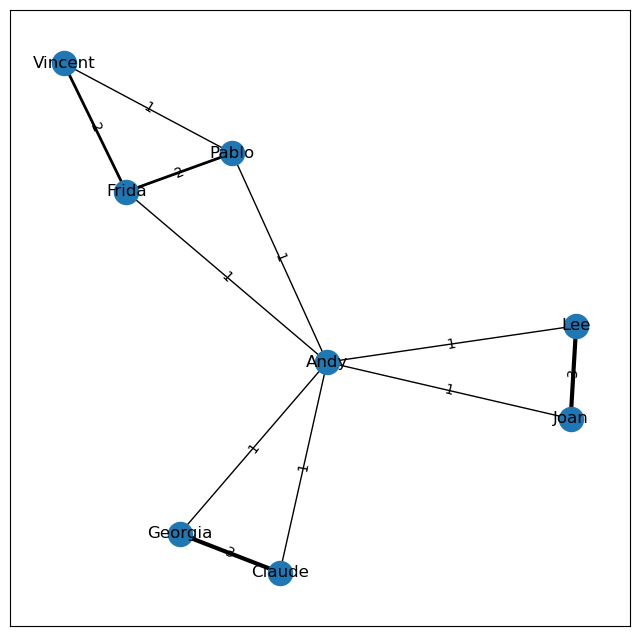

In [54]:
G = answer_three()
plot_graph(G, weight_name="weight")
G.edges(data = True)

In [55]:
assert type(answer_three()) == nx.Graph , "Your return type should be a Graph object"


### Question 4

Suppose you'd like to find out if people that have a high relationship score also like the same types of movies.

Find the pearson correlation between employee relationship scores and the number of movies they have in common. If two employees have no movies in common it should be treated as a 0, not a missing value, and should be included in the correlation calculation.

*This function should return a float.*

In [164]:
def answer_four():
    df = pd.read_table("assets\Employee_Relationships.txt", delimiter="\t",
                  header=None, names=["Who","Whom","Relation"])

    relation = nx.from_pandas_edgelist(df= df, source="Who",
                            target="Whom", edge_attr="Relation")

    df_relation = pd.DataFrame(relation.edges(data=True),
                               columns=["Who","Whom","Relation"]) 
    df_relation["Relation"] = df_relation.apply(lambda x: x.Relation["Relation"],
                                                axis=1)

    G = answer_three()
    df_movie = pd.DataFrame(G.edges(data = True), 
                            columns=["Who","Whom","weight"])
    df_movie["weight"] = df_movie.apply(lambda x: x.weight["weight"], 
                                        axis=1)
    
    # a->b이거나 b->a 일 수도 있기 때문에 이걸 처리해주기 위해서 필요한 코드
    d_rel = df_movie.copy()
    d_rel = d_rel.rename(columns={"Who":"Whom_",
                          "Whom":"Who"}) \
         .rename(columns={"Whom_":"Whom"})

    concat_df = pd.concat([d_rel, df_movie])

    return_value = pd.merge(df_relation,concat_df, on=["Who","Whom"],how="left") \
                            .fillna(0)   \
                            .corr()      \
                            .iloc[0,1]
    return return_value

In [105]:
ans_four = answer_four()